![Fraud](./img/Fraud.png)
# Employment Scam Aegean Dataset
## 0. Imports and global settings

In [1]:
import library as lib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import FreqDist, RegexpTokenizer, word_tokenize
import pandas as pd
import re
import seaborn as sns
import string
import warnings
from wordcloud import WordCloud

sns.set(palette='RdYlGn', context='talk', rc={'figure.figsize':(15,15)})
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

## 0.1 Creating dataframes

In [2]:
df = pd.read_csv("./fake_job_postings.csv",index_col='job_id')

In [3]:
dflegit = df[df['fraudulent']==0]
dffraud = df[df['fraudulent']==1]

In [4]:
df

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0


In [5]:
df.sample(n=50)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
4999,Product Manager,"US, NY, New York",NaN,NaN,Recombine provides clinical genetic testing. C...,Recombine seeks to develop the most comprehens...,"About You• Master’s or PhD in Genetics, Geneti...",Participate and contribute to an environment w...,0,1,0,Full-time,NaN,NaN,NaN,Product Management,0
3309,"Director, Food Safety and Quality Assurance","CA, QC, Boisbriand",NaN,NaN,NaN,The Food Safety and Quality Assurance (FSQA) D...,Minimum Experience and Qualification Requireme...,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,0
2972,SQA Engineer,"US, CA, San Jose",NaN,0-0,NaN,"Qualifications: Bachelors degree, 4-5 years ex...",NaN,NaN,0,0,0,Contract,Mid-Senior level,Bachelor's Degree,Medical Devices,Quality Assurance,0
13976,Marketing Director,"AE, DU, Dubai",Marketing,NaN,MarkaVIP is the leading online fashion destina...,MarkaVIP is looking for a rockstar marketing p...,Lead and manage all aspects of direct-to-consu...,Competitive SalaryExciting and fast growing st...,0,1,1,Full-time,Director,Bachelor's Degree,Apparel & Fashion,Marketing,0
7518,Senior Application Engineer ( MACsec/FCoE ),"US, CA, Irvine",NaN,135-165,Roland &amp; Associates is a Corporate Recruit...,You will interface with both customers and our...,Job Role : Senior Application Engineer (...,Base Salary : $135000.00 to 165000.00Benefits ...,0,1,0,NaN,NaN,NaN,NaN,NaN,0
9245,English Teacher Abroad,"US, WY, Laramie",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,NaN,Bachelor's Degree,Education Management,NaN,0
3945,Collections Supervisor,"US, NV, Las Vegas",NaN,NaN,Tidewater Finance Co. was established in 1992 ...,West Coast Service Center Collections Supervis...,Requirements: Five years collection experience...,Our company offers a competitive salary plus B...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Financial Services,Management,0
11731,Android Developer (Kit Kat Kruncher),"SG, ,",NaN,NaN,We’re not doctors. We are geeks who understand...,Been to the doctor lately? Ever thought it odd...,2-3 years experience in native Android develop...,"Don’t worry, we aren’t the only ones profiting...",0,1,1,Full-time,NaN,Bachelor's Degree,Information Technology and Services,NaN,0
16973,Commercial Electricians Needed,"US, ,",NaN,NaN,We bring you strong solutions!With the complex...,Immediate need for Journeyman Electricians! Cu...,Candidate Requirements7+ years’ experience as ...,NaN,0,1,1,Contract,Associate,Certification,Construction,Project Management,0


## 1. Missing values
Let's have a look at the data and see if there are any missing values.

In [6]:
_nalegit = pd.DataFrame(index=['Legit_HasValue','Legit_IsNA'])
_nafraud = pd.DataFrame(index=['Fraud_HasValue', 'Fraud_IsNA'])
for header in dflegit.columns:
    _nalegit[header] = dflegit[header].isna().value_counts()[0]
_nalegit.loc['Legit_IsNA'] = 17014 - _nalegit.loc['Legit_HasValue']
for header in dffraud.columns:
    _nafraud[header] = dffraud[header].isna().value_counts()[0]
_nafraud.loc['Fraud_IsNA'] = 866 - _nafraud.loc['Fraud_HasValue']
_nalegit = (round(_nalegit/17014*100, 1)).T
_nafraud = (round(_nafraud/866*100,1)).T
_na = _nalegit.merge(_nafraud,how='inner',left_on=_nalegit.index, right_on=_nafraud.index)
_na = _na.set_index(_na['key_0']).drop(columns='key_0')
_na.index.names = ['Columns']
_na

,Legit_HasValue,Legit_IsNA,Fraud_HasValue,Fraud_IsNA
Columns,,,,
title,100.0,0.0,100.0,0.0
location,98.1,1.9,97.8,2.2
department,35.3,64.7,38.7,61.3
salary_range,15.5,84.5,25.8,74.2
company_profile,84.0,16.0,32.2,67.8
description,100.0,0.0,99.9,0.1
requirements,85.1,14.9,82.2,17.8
benefits,59.8,40.2,58.0,42.0
telecommuting,100.0,0.0,100.0,0.0


17014


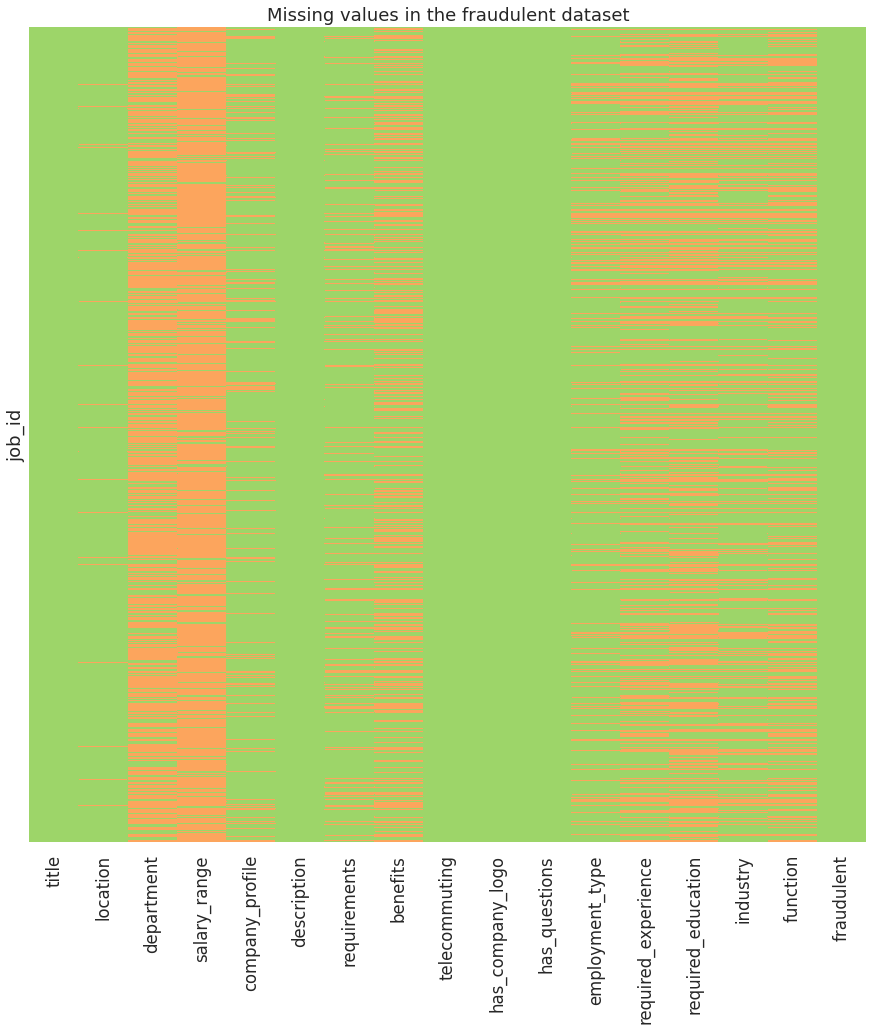

In [7]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


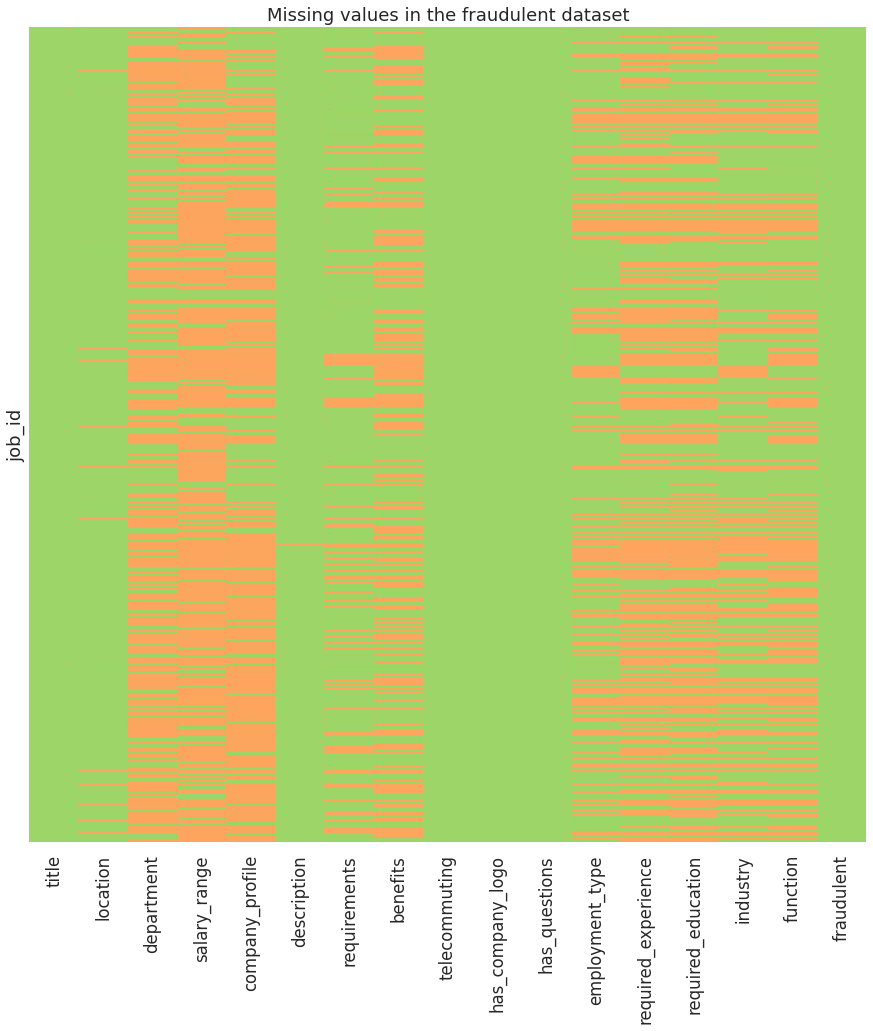

In [8]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

## 1.1 Insight
This dataset contains 17880 jobs, with a maximum of 16 characteristics given to each job. On top of this information, all jobs entry have been assigned manually a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers flagged as genuine whilst 866 were identified as fraudulent.

_Note: This assignment was done manually. Errors might have occurred._

The informations given for each job is separated in the following variables:

| Number | Title | Data type |
|---:|:---:| ---|
| 01 | title | text |
| 02 | location | text |
| 03 | department | text |
| 04 | salary_range | text |
| 05 | company_profile | text |
| 06 | description | text |
| 07 | requirements | text |
| 08 | benefits | text |
| 09 | telecommuting | binary |
| 10 | has_company_logo | binary |
| 11 | has_questions | binary |
| 12 | employment_type | categorical |
| 13 | required_experience | categorical |
| 14 | required_education | categorical |
| 15 | industry | categorical |
| 16 | function | categorical |
| 17 | fraudulent | binary |

There tend to be some repetitions in some fields; `company_profile` is an obvious one but, `description` can be very similar in some cases. These repetitions might affect tf-idf scores and might require a more in-depth analysis.

As the missing table shows, fraudulent posts tend to have more missing values than legitimate job posts, especially when it comes down to company profile. However, they seem to be rather keen on giving information about the salary range. Only one job doesn't have a job description (`df[df['description'].isna()==True]`); it is a fraudulent post for a position as an Office Manager in Warsaw, PL.

## 2. Text fields
From the missing value visualisation, we can see the fraudsters are struggling with the company profiles, etc. Let's look at text fields, in general, to see how creative the fraudsters are.
### 2.1 Trimming the text
There is some textual artefact that ned to be removed in order to have a more efficient word analysis.

In the following code,
- The first line will put a space before every capital letter (to avoid a wo.Rd scenario).
- The second line will remove the anonymised contact information.
- The third line will remove non-word characters, including digits.
- The fourth line will remove words shorter than three characters.
- The fifth line will convert multiple spaces into one space only.

In [9]:
for column in df.columns[4:8]:
    df[column].replace('([A-Z][a-z]|[A-Z] )', r' \1', regex=True, inplace=True)
    df[column].replace('(#URL\w+|#PHONE\w+|#EMAIL\w+)', ' ', regex=True, inplace=True)
    df[column].replace('(\\W|\\d)', ' ', regex=True, inplace=True)
    df[column].replace(r'\b\w{1,3}\b', ' ', regex=True, inplace=True)
    df[column].replace('\ +', ' ', regex=True, inplace=True)

### 2.2 Word Count

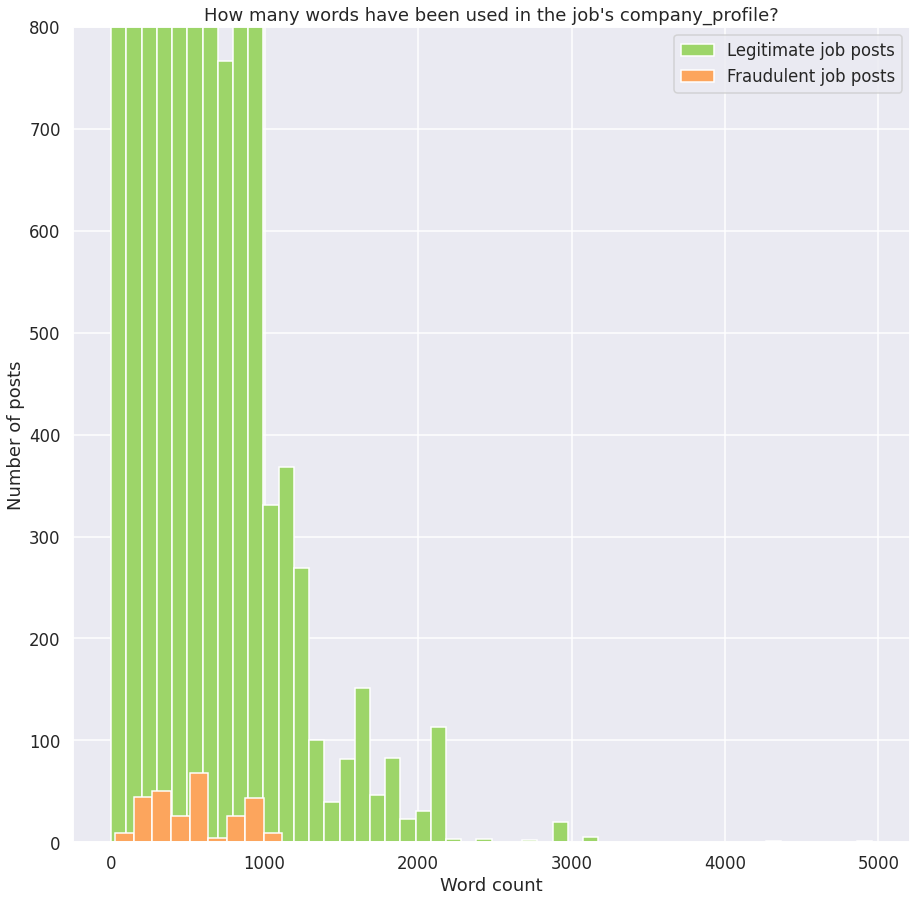

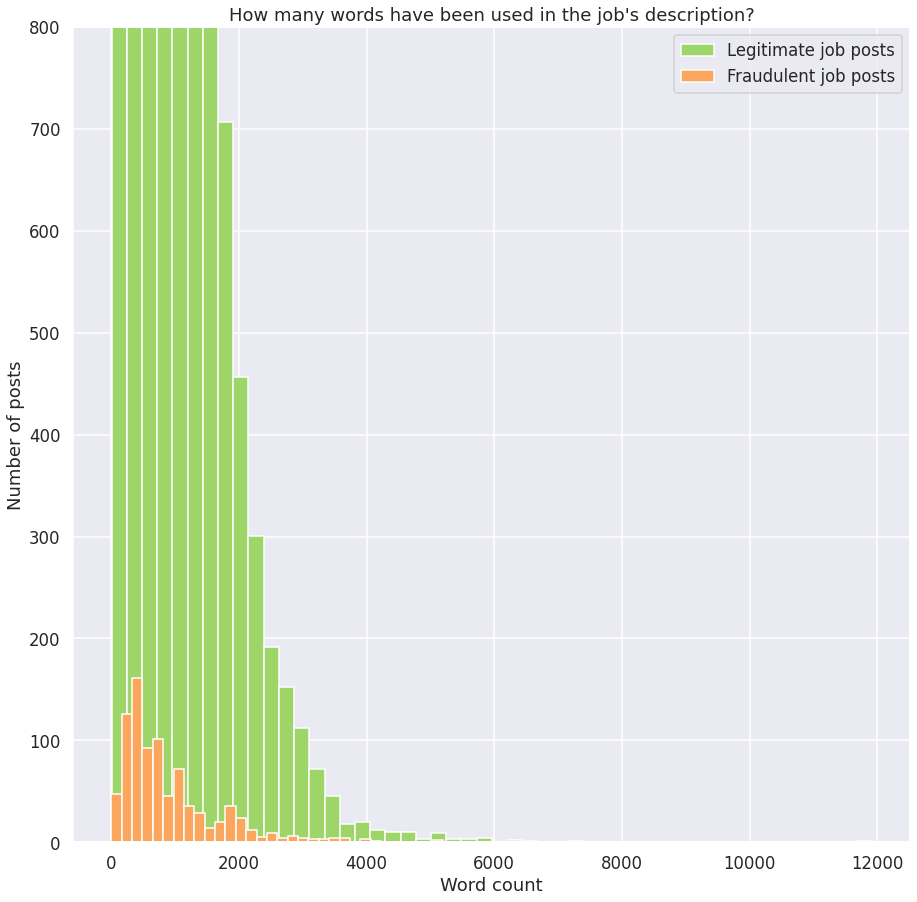

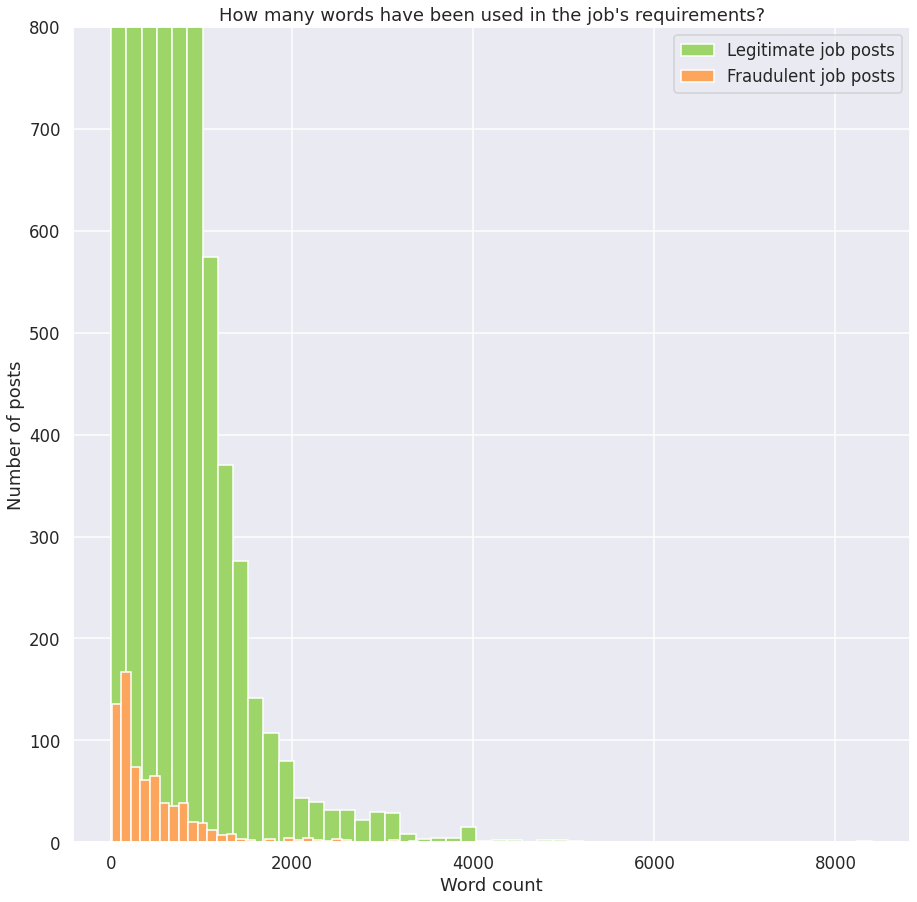

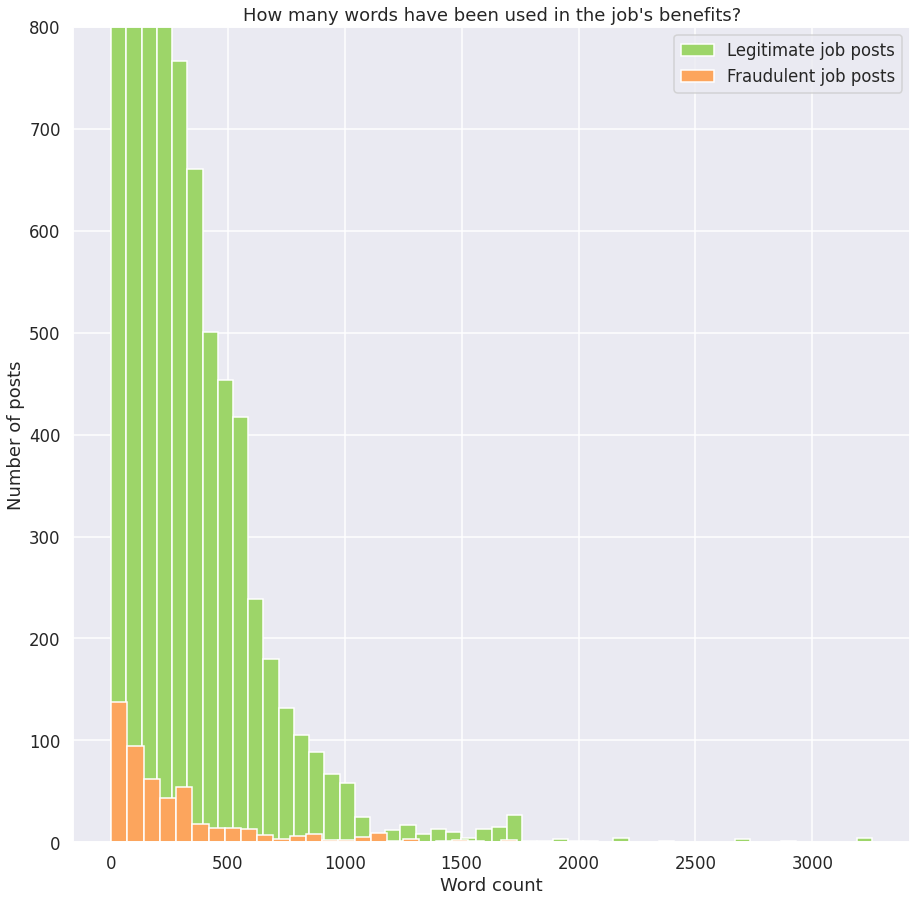

In [10]:
lib.word_dist_plot(df,4,8)

Not only are fraudulent job posts less complete than legitimate ones but, even when there is information, the fraudulent job posts are less loquacious than genuine job posts. This is especially true for job requirements and company_profile.

Let's have a more detailed look at the content itself.
### 2.3 Word Analysis

In [11]:
# Removing stopwords
stop_words = list(string.punctuation)
stop_words += stopwords.words('english')
stop_words += [i for i in 'qwertyuioplkjhgfdsazxcvbnm']

In [12]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['company_profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

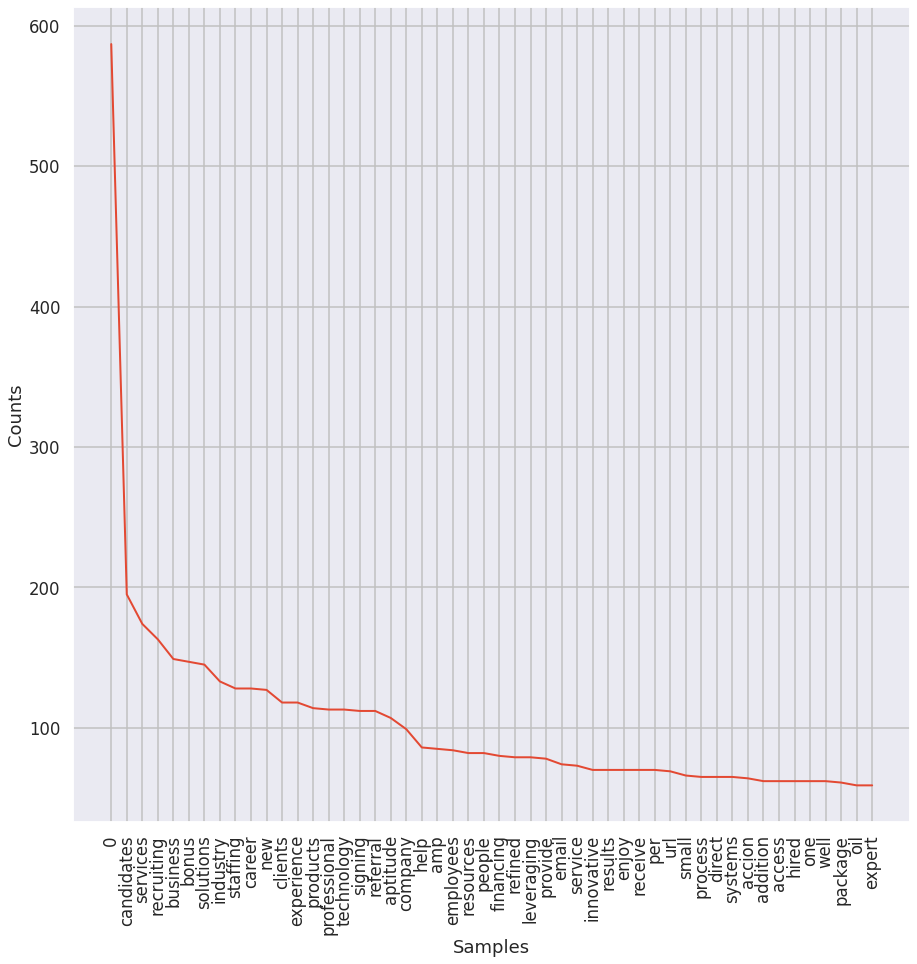

In [13]:
FreqDist(tokens_cp).plot(50)
plt.show()

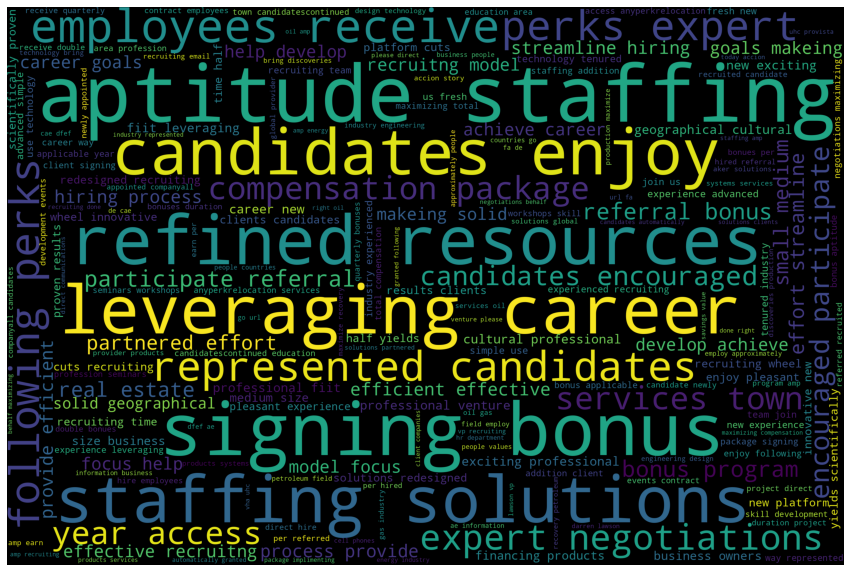

In [14]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [15]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['company_profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [16]:
len(tokens_cp)
# 948364 for df
# 18771 for dffraud
# 1019554 for dflegit

1019554

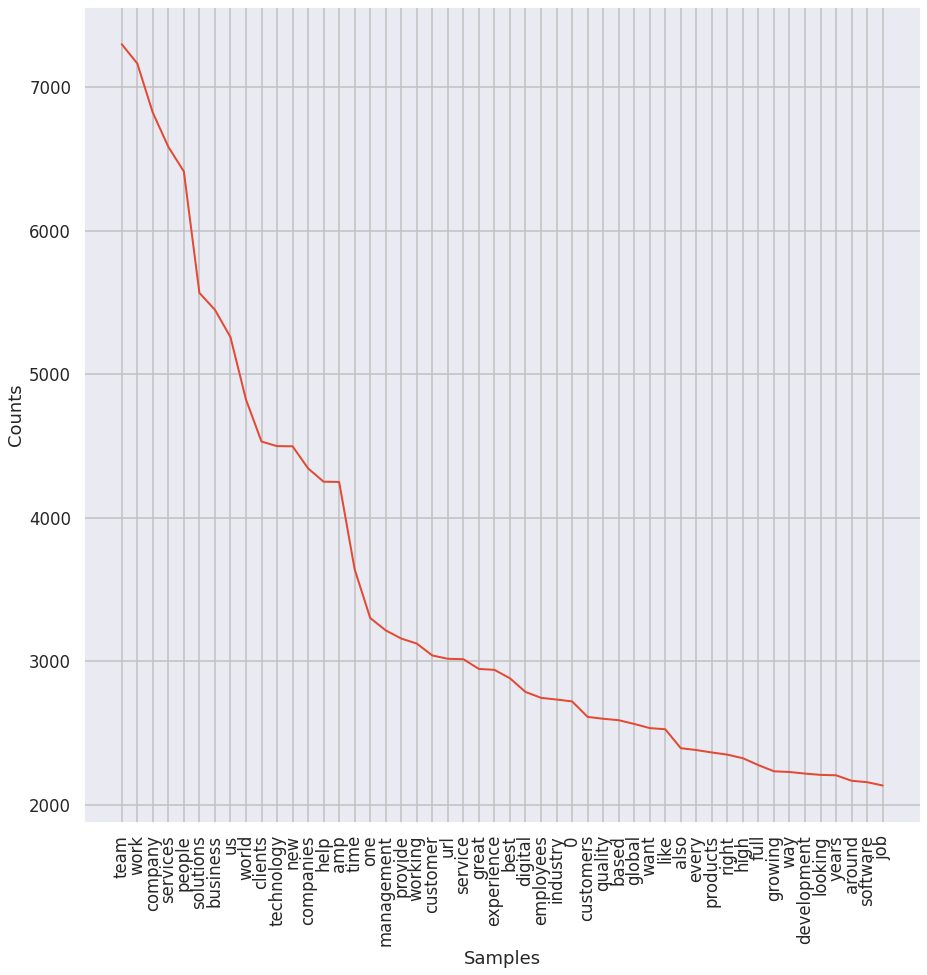

In [17]:
FreqDist(tokens_cp).plot(50)
plt.show()

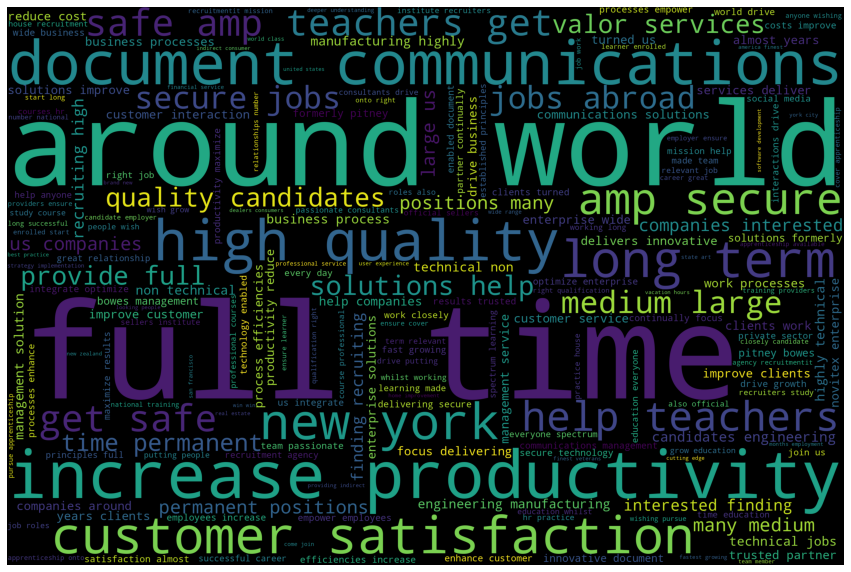

In [18]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Looking at the content of fraudulent ads, it appears, the company profile would be more individual focussed, with terms like candidates, recruiting, bonus, staffing, career, signing, referral, etc.

A legitimate company seem to be more mission focussed with terms like team, people, solutions, help, business, etc.
## 3. Categorical information

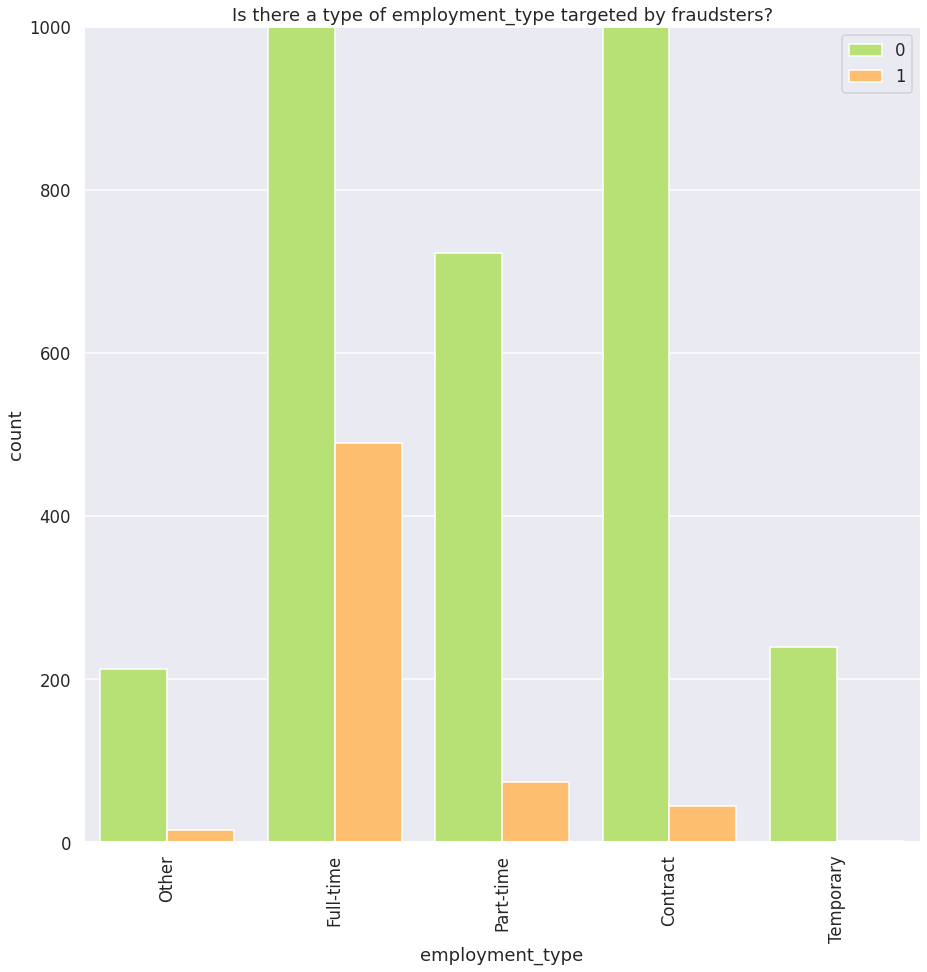

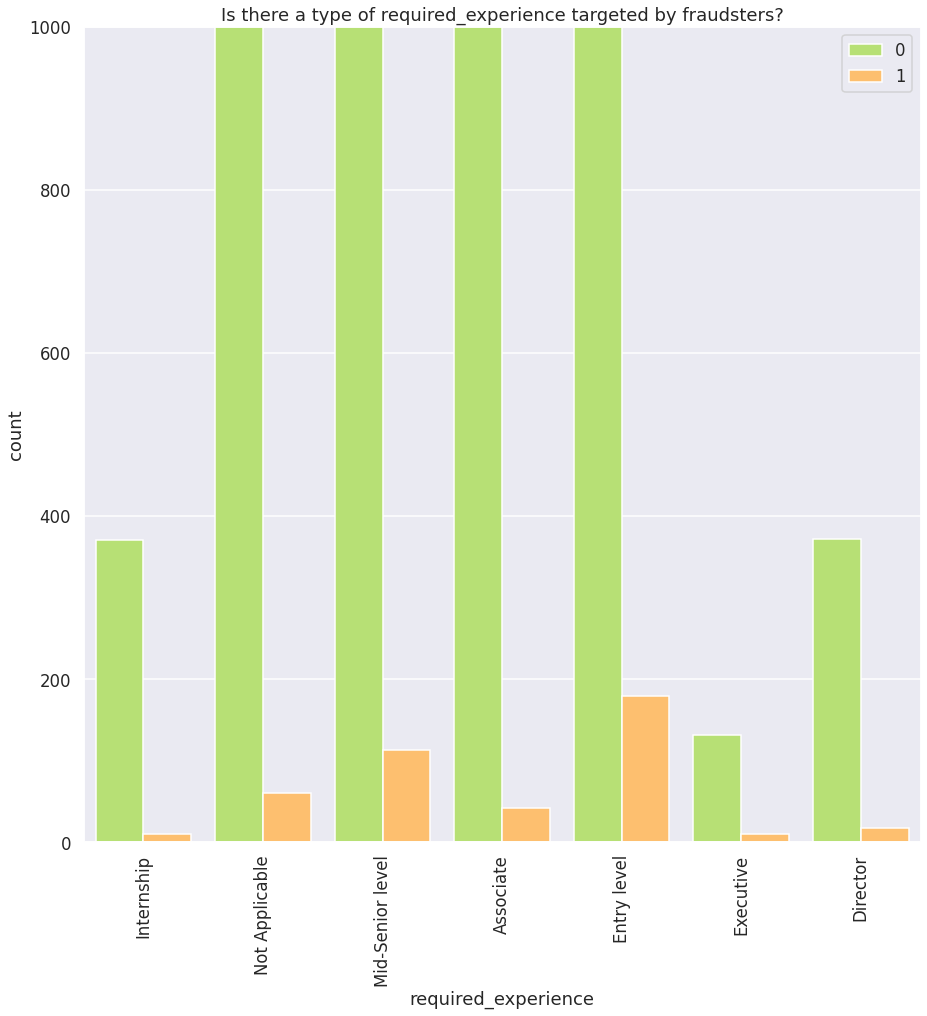

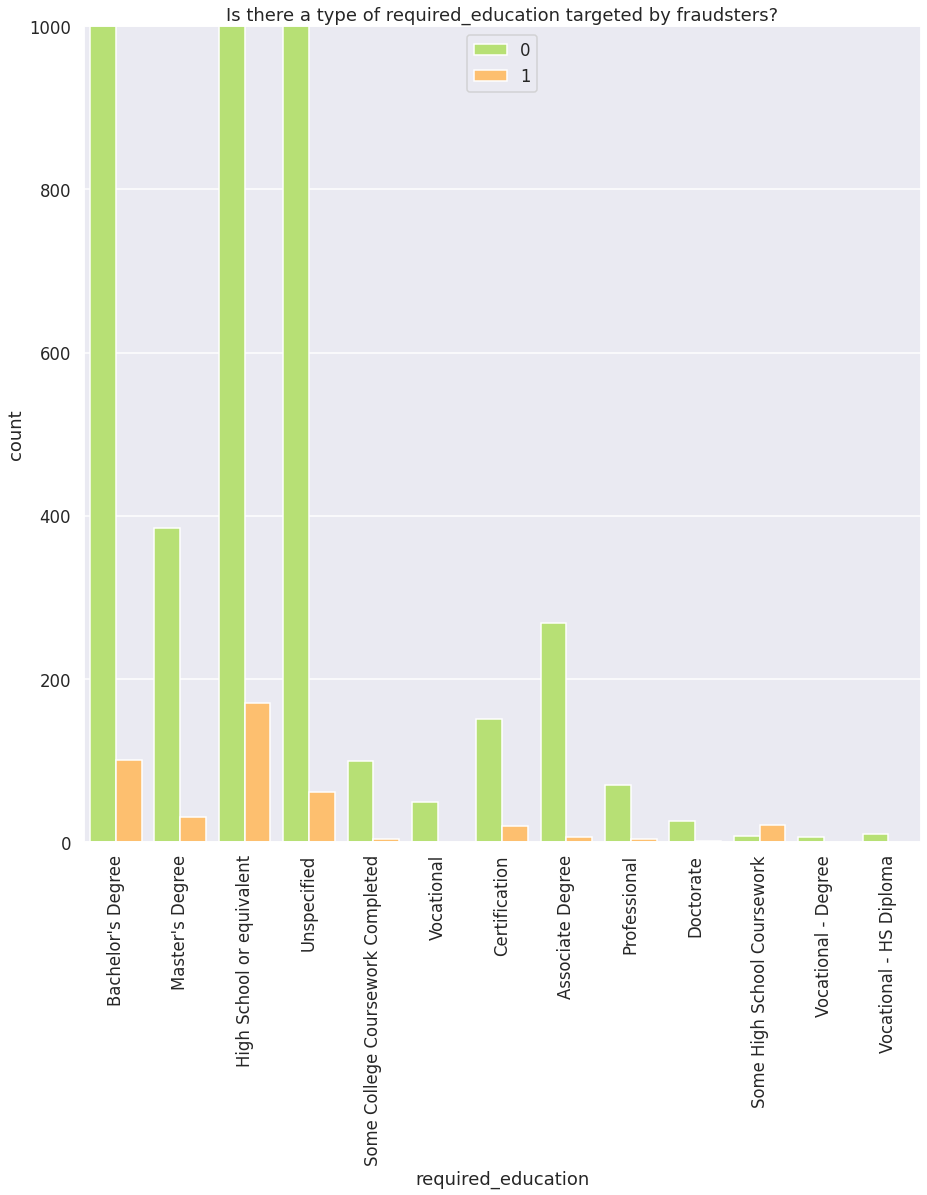

In [19]:
lib.count_plot(df,11,14)

## 4. Extracting extra information

Some job offers have a phone, email and/or external URL information:

In [20]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)
    
df = df.assign(hasEMAIL=0, hasPHONE=0, hasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['hasURL'][i] = 1
        elif df[column][i].find('#PHONE_')!=-1:
            df['hasPHONE'][i] = 1
        elif df[column][i].find('#EMAIL_')!=-1:
            df['hasEMAIL'][i] = 1

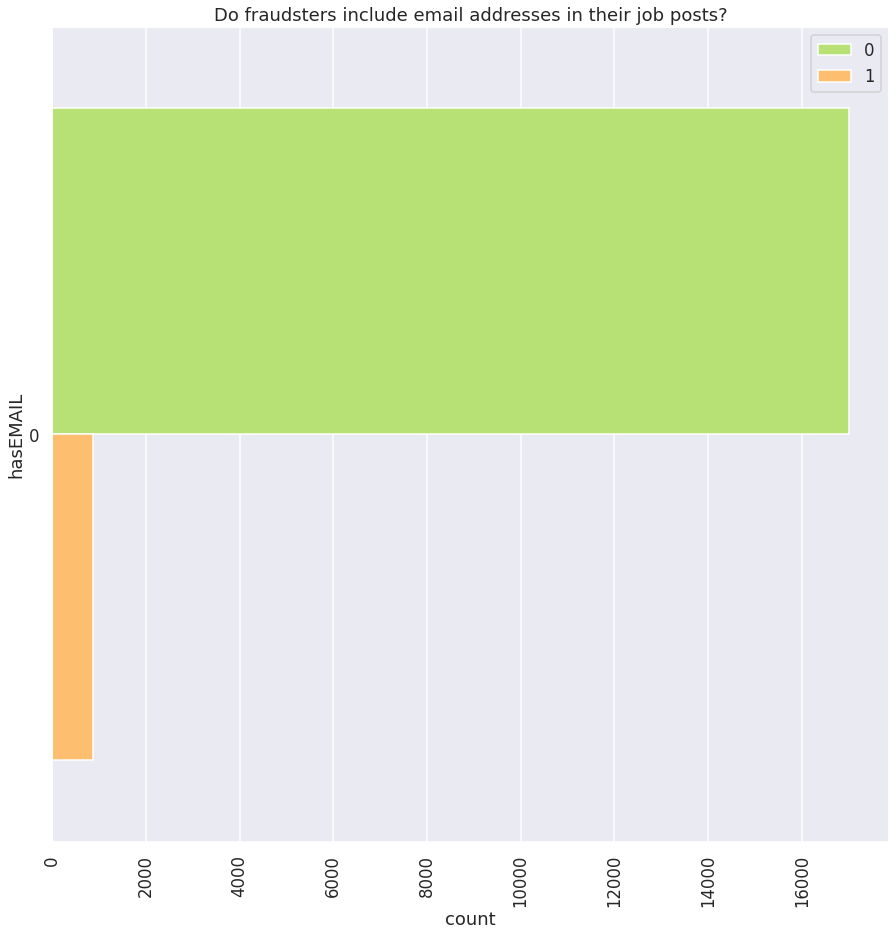

In [21]:
sns.countplot(y='hasEMAIL', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include email addresses in their job posts?")
plt.xticks(rotation=90);
plt.legend();

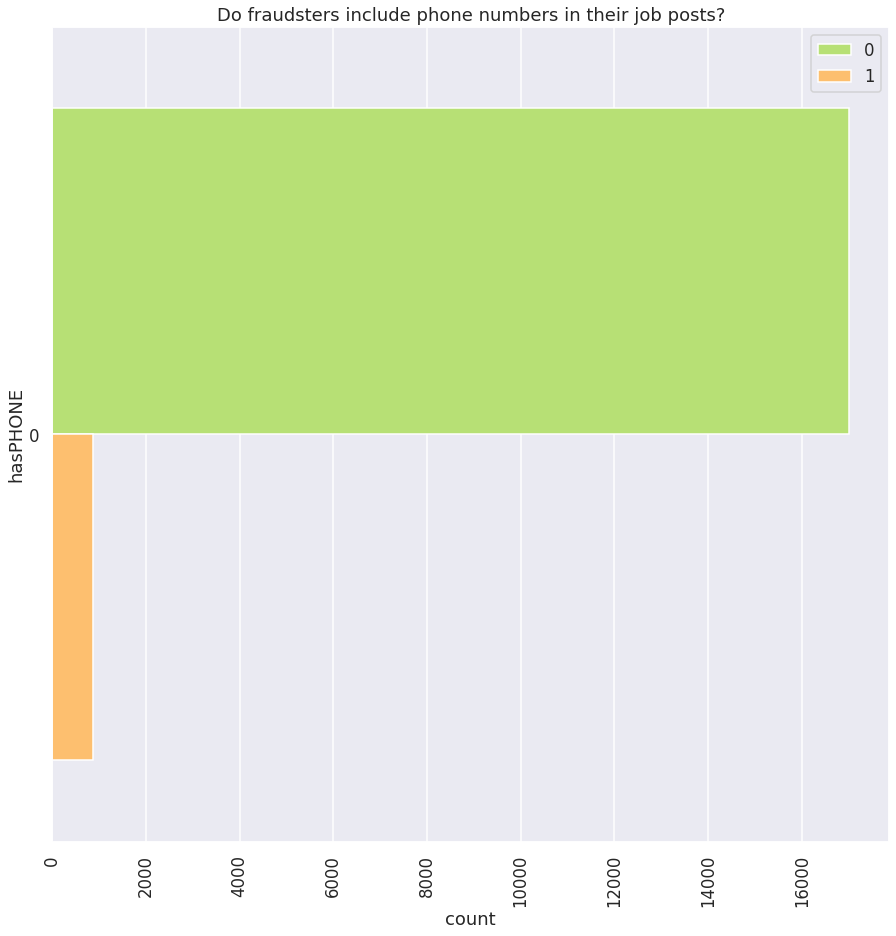

In [22]:
sns.countplot(y='hasPHONE', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include phone numbers in their job posts?")
plt.xticks(rotation=90);
plt.legend();

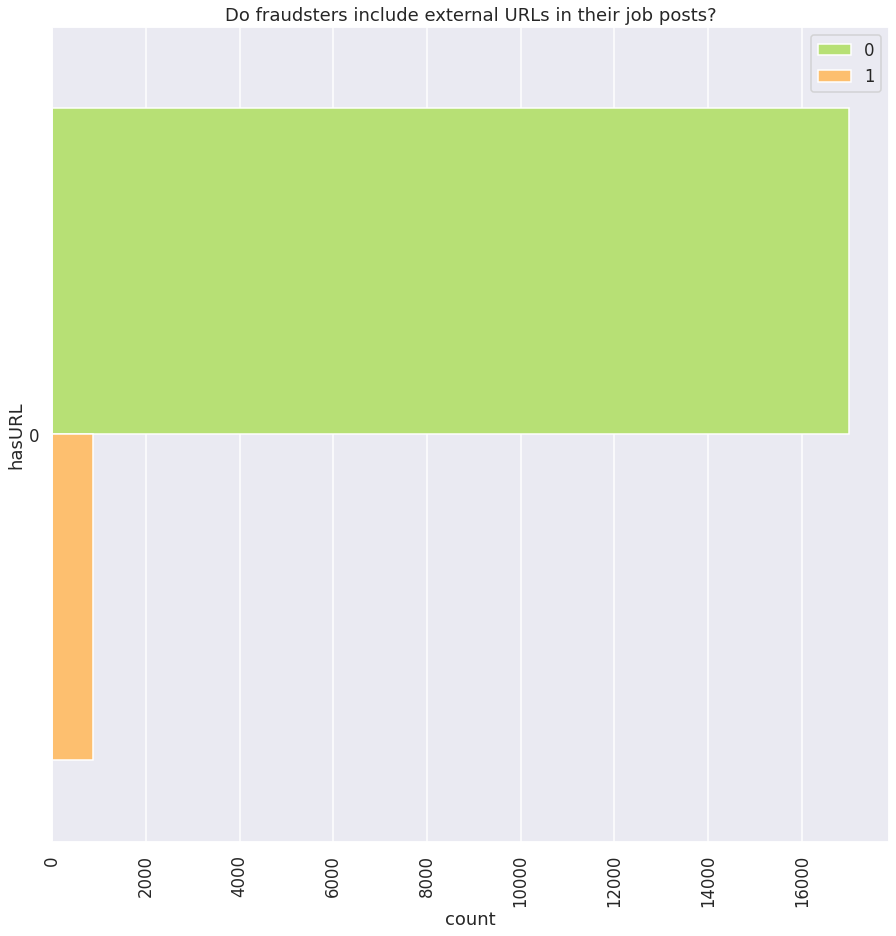

In [23]:
sns.countplot(y='hasURL', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include external URLs in their job posts?")
plt.xticks(rotation=90);
plt.legend();

## 5. Conclusion
Unfortunately looking at the metadata is not going to be enough to identify fraudulent job posts. The fraudulent job posts follow the same pattern as legitimate job posts except:
* they tend to be lacking more information than the genuine job offers but, fraudsters will make an effort for information such as location, department, function and especially salary_range.
* when information is provided, it will tend to be shorter, the text is going to be more succinct. This characteristic is especially true for the company profile and the job requirements fields.

In terms of content, fraudulent posts will:
* target 'High school degrees or equivalent' and 'Bachelor's Degree' more than any other type of education; Doctorate, Associate Degrees and Vocational were not particularly targeted, some even not targeted at all (in this dataset at least).
* mostly advertise full-time and part-time positions. There are a few fraudulent contractor positions but, proportionally less than any other type of position and temporary contracts were not targeted at all (in this dataset at least).
* target all types of experience but mainly entry-level positions. Once again, Associates are less exposed whilst Directors, Executive and Mid-Senior levels are a little less exposed too.
* tend to refer an URL.  This URL is potentially linking to a website that will infect the victim's computer but, as phone, emails and URLs have been anonymised, it is impossible to confirm this hypothesis.
* NOT communicate a phone number. But most job ads don't anyways.

I hope this gives you a little bit more understanding of fraudulent job offers. The [following notebook](./index.ipynb) will go deeper in the analysis of this dataset and will result in the creation of a classification model helping identify the legitimacy of job posts.